# RihkyeTask + LSTM_MD model

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from task import RihkyeTask
import sys
sys.path.append('..')
from temp_model import MD, LSTM_MD

## Dataset

In [2]:
num_cueingcontext = 2
num_cue = 2
num_rule = 2
rule = [0, 1, 0, 1]
blocklen = [500, 500, 200]
block_cueingcontext = [0, 1, 0]
tsteps = 200
cuesteps = 100
batch_size = 1 # always set to 1 right now

dataset = RihkyeTask(num_cueingcontext=num_cueingcontext, num_cue=num_cue, num_rule=num_rule, rule=rule, blocklen=blocklen, \
block_cueingcontext=block_cueingcontext, tsteps=tsteps, cuesteps=cuesteps, batch_size=batch_size)

## Model

## Training

In [3]:
import time

# Model settings
input_size = 4 # 4 cues
hidden_size = 200
output_size = 2 # 2 rules
num_layers = 1
Num_MD = 10
num_active = 5
tsteps = 200

model = LSTM_MD(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, Num_MD=Num_MD, \
    num_active=num_active, tsteps=tsteps)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


total_step = sum(blocklen)//batch_size
print_step = 10
running_loss = 0.0
running_train_time = 0
losses = []
timestamps = []
model_name = 'model-' + str(int(time.time()))
savemodel = False


for i in range(total_step):

    train_time_start = time.time()

    # extract data
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs, labels)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # normalization
    optimizer.step()

    # print statistics
    running_train_time += time.time() - train_time_start
    running_loss += loss.item()

    if i % print_step == (print_step - 1):
        print('Total step: {:d}'.format(total_step))
        print('Training sample index: {:d}-{:d}'.format(i+1-print_step, i+1))

        # running loss
        print('loss: {:0.5f}'.format(running_loss / print_step))
        losses.append(running_loss / print_step)
        timestamps.append(i+1-print_step)
        running_loss = 0.0

        # training time
        print('Predicted left training time: {:0.0f} s'.format(
        (running_train_time) * (total_step - i - 1) / print_step),
        end='\n\n')
        running_train_time = 0

        if savemodel:
            # save model every print_step
            fname = os.path.join('models', model_name + '.pt')
            torch.save(model.state_dict(), fname)

            # save info of the model
            fpath = os.path.join('models', model_name + '.txt')
            with open(fpath, 'w') as f:
                f.write('input_size = ' + str(input_size) + '\n')
                f.write('hidden_size = ' + str(hidden_size) + '\n')
                f.write('output_size = ' + str(output_size) + '\n')
                f.write('num_layers = ' + str(num_layers) + '\n')


print('Finished Training')

Total step: 1200
Training sample index: 0-10
loss: 0.35947
Predicted left training time: 455 s

Total step: 1200
Training sample index: 10-20
loss: 0.20197
Predicted left training time: 340 s

Total step: 1200
Training sample index: 20-30
loss: 0.11952
Predicted left training time: 339 s

Total step: 1200
Training sample index: 30-40
loss: 0.05078
Predicted left training time: 293 s

Total step: 1200
Training sample index: 40-50
loss: 0.03651
Predicted left training time: 353 s

Total step: 1200
Training sample index: 50-60
loss: 0.02727
Predicted left training time: 393 s

Total step: 1200
Training sample index: 60-70
loss: 0.02678
Predicted left training time: 284 s

Total step: 1200
Training sample index: 70-80
loss: 0.02392
Predicted left training time: 282 s

Total step: 1200
Training sample index: 80-90
loss: 0.02053
Predicted left training time: 284 s

Total step: 1200
Training sample index: 90-100
loss: 0.01986
Predicted left training time: 282 s

Total step: 1200
Training samp

Predicted left training time: 90 s

Total step: 1200
Training sample index: 830-840
loss: 0.00292
Predicted left training time: 94 s

Total step: 1200
Training sample index: 840-850
loss: 0.00289
Predicted left training time: 88 s

Total step: 1200
Training sample index: 850-860
loss: 0.00274
Predicted left training time: 85 s

Total step: 1200
Training sample index: 860-870
loss: 0.00272
Predicted left training time: 87 s

Total step: 1200
Training sample index: 870-880
loss: 0.00267
Predicted left training time: 81 s

Total step: 1200
Training sample index: 880-890
loss: 0.00261
Predicted left training time: 77 s

Total step: 1200
Training sample index: 890-900
loss: 0.00253
Predicted left training time: 78 s

Total step: 1200
Training sample index: 900-910
loss: 0.00246
Predicted left training time: 75 s

Total step: 1200
Training sample index: 910-920
loss: 0.00247
Predicted left training time: 72 s

Total step: 1200
Training sample index: 920-930
loss: 0.00240
Predicted left train

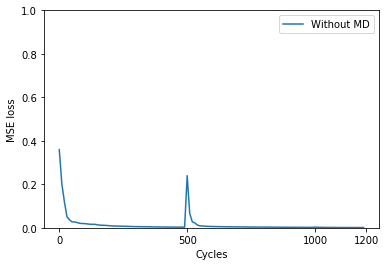

In [4]:
import matplotlib.pyplot as plt

plt.plot(timestamps, losses, label='Without MD')
plt.xlabel('Cycles')
plt.ylabel('MSE loss')
plt.legend()
plt.xticks([0, 500, 1000, 1200])
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

In [5]:
# deprecated
#lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1, proj_size=2)
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)
input = torch.randn(5, 3, 10)
#h0 = torch.randn(1, 3, 20)
#c0 = torch.randn(1, 3, 20)
output, _= lstm(input)

print(output.shape)

torch.Size([5, 3, 20])
